In [1]:
import time
import warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 경고 메시지 무시
warnings.filterwarnings(action='ignore')

# 설정 변수 정의

In [2]:
## 작업 디렉토리 정의
# 학습 데이터 파일명
train_list_file = "./images.npy"
# 라벨 데이터 파일명
label_list_file = "./masks.npy"
# 분석 모델 디렉토리명ㅣ
modeldir = "./model/CRACK-UNET-28"
# 로그 디렉토리명
logdir = "./logs"

## 학습 데이터 설정
# 학습할 데이터의 개수
training_count = 40

## 최적화 함수 설정
# 최적화 함수 학습률
learning_rate = 0.00001  # 0.0001 → 0.00001

## 학습 수행 설정
# 최대 학습 수행 횟수
epoch_count = 10000  # 5000
# 학습 중단시킬 최소 loss값
loss_limit = 0.00001  # 0.001
# loss값 지속 횟수
loss_retain_limit = 5

# 모델 생성을 위한 연산 함수 생성

## 합성곱 연산 생성 함수

In [3]:
def conv(in_x, filters, kernel_size=5, stride=1, activation=tf.keras.activations.relu, name=None):
    
    x = tf.keras.layers.Conv2D(filters = filters, kernel_size = kernel_size, strides = [stride, stride], padding = "same", activation = None)(in_x)
    x = tf.keras.layers.BatchNormalization()(x)
    if(name == None):
        x = activation(x)
    else:
        x = activation(x, name=name)
    
    return x

## 폴링 연산 생성 함수

In [4]:
def maxpool(in_x, pool_size=2, stride=2):
    return tf.keras.layers.MaxPool2D(pool_size=(pool_size, pool_size), strides=stride)(in_x)

## up-sampling, up-convolution 연산 생성 함수

In [5]:
def upconv(in_x, filters, kernel_size=5, stride=2, activation=tf.keras.activations.relu):
    
    x = tf.keras.layers.Conv2DTranspose(filters = filters, kernel_size = kernel_size, strides = (stride, stride), padding = "same", activation = None)(in_x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation(x)
    
    return x

## 합성곱 결과를 복사하여 붙이는 연산 생성 함수
붙이는 작업 수행 시, 원본(source)과 목적(target) 합성곱의 크기가 다를 경우,<br>
원본의 크기를 목적 합성곱 함수에 맞도록 잘라서(crop) 붙임

In [6]:
def copyAndCrop(source, target):
    
    # 입력이미지를 목표이미지의 크기에 맞게
    # 잘라내는 과정
    source_h = int(source.get_shape().as_list()[1])
    source_w = int(source.get_shape().as_list()[2])
    
    target_h = int(target.get_shape().as_list()[1])
    target_w = int(target.get_shape().as_list()[2])
    
    offset_h = int((source_h - target_h)/2)
    offset_w = int((source_w - target_w)/2)
    
    # 3차원 텐서, 세로 좌표, 가로 좌표, 결과 높이, 결과 너비
    # 3D tensor of image with shape [target_height, target_width, channels]
    crop = tf.image.crop_to_bounding_box(source, offset_h, offset_w, target_h, target_w)
    
    # copy 과정
    # 잘라낸 이미지(crop) 과 목표 이미지(target) 과 합침 
    copy = tf.concat([crop, target], -1)
    
    return copy

## 원본(data), 예측(pred), 라벨(label) 데이터를 화면에 표시하는 함수

In [7]:
def showCrack(data, pred, label):
    
    # pyplot의 현재 전체 이미지 크기를 백업 후 설정함
    tmp_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (15,7)  # 너비, 높이 (in)
    
    # 원본 데이터 출력
    plt.subplot(1,3,1)  # 한 번에 여러 그래프 출력
    plt.imshow(data.reshape([448,448]), cmap='gray')
    plt.axis('off')
    
    # 예측 데이터 출력
    plt.subplot(1,3,2)
    plt.imshow(pred.reshape([448,448]), cmap='gray')
    plt.axis('off')
    
    # 라벨 데이터 출력
    plt.subplot(1,3,3)
    plt.imshow(label.reshape([448,448]), cmap='gray')
    plt.axis('off')    
    
    plt.show()
    plt.close()
    
    # 백업된 pyplot 이미지 크기를 복원함
    plt.rcParams["figure.figsize"] = tmp_size

# 모델 생성
<변수 명명 규칙><br>
→ [과정코드][연산종류코드]_[층수]_[순번]<br>
<br>
과정코드 : d(down), b(bottle-neck), u(up)<br>
연산종류코드 : c(conv), p(pooling), u(upconv), x(copy and crop)<br>
층수는 U-Net의 가장 상위층을 1층으로 하여, 하위로 내려갈수록 높아짐<br>

In [8]:
# 균열 이미지 입력 Tensor
x = tf.placeholder(tf.float32, [None, 448, 448, 1], name="in")

base_filter_cnt = 16

# 압축과정(down) : U의 내려가는 부분
dc_1_1 = conv(x, base_filter_cnt)
dc_1_2 = conv(dc_1_1, base_filter_cnt)
dp_1 = maxpool(dc_1_2)
print('dp_1 : {}'.format(dp_1))

dc_2_1 = conv(dp_1, base_filter_cnt*2)
dc_2_2 = conv(dc_2_1, base_filter_cnt*2)
dp_2 = maxpool(dc_2_2)
print('dp_2 : {}'.format(dp_2))

dc_3_1 = conv(dp_2, base_filter_cnt*4)
dc_3_2 = conv(dc_3_1, base_filter_cnt*4)
dp_3 = maxpool(dc_3_2)
print('dp_3 : {}'.format(dp_3))

# 4 layer 추가
dc_4_1 = conv(dp_3, base_filter_cnt*8)
dc_4_2 = conv(dc_4_1, base_filter_cnt*8)
dp_4 = maxpool(dc_4_2)
print('dp_4 : {}'.format(dp_4))

# 5 layer 추가
dc_5_1 = conv(dp_4, base_filter_cnt*16)
dc_5_2 = conv(dc_5_1, base_filter_cnt*16)
dp_5 = maxpool(dc_5_2)
print('dp_5 : {}'.format(dp_5))

# 병목(bottle-neck) : 특징 압축, U의 바닥 부분
bc_6_1 = conv(dp_5, base_filter_cnt*32)
bc_6_2 = conv(bc_6_1, base_filter_cnt*32)
print('\nbc_6_2 : {}'.format(bc_6_2))

# 확장과정(up) : U의 올라가는 부분
uu_5 = upconv(bc_6_2, base_filter_cnt*16)
ux_5 = copyAndCrop(uu_5, dc_5_2)
uc_5_1 = conv(ux_5, base_filter_cnt*16)
uc_5_2 = conv(uc_5_1, base_filter_cnt*16)
print('\nuc_5_2 : {}'.format(uc_5_2))

uu_4 = upconv(bc_5_2, base_filter_cnt*8)
ux_4 = copyAndCrop(uu_4, dc_4_2)
uc_4_1 = conv(ux_4, base_filter_cnt*8)
uc_4_2 = conv(uc_4_1, base_filter_cnt*8)
print('nuc_4_2 : {}'.format(uc_4_2))

uu_3 = upconv(bc_4_2, base_filter_cnt*4)
ux_3 = copyAndCrop(uu_3, dc_3_2)
uc_3_1 = conv(ux_3, base_filter_cnt*4)
uc_3_2 = conv(uc_3_1, base_filter_cnt*4)
print('nuc_3_2 : {}'.format(uc_3_2))

uu_2 = upconv(uc_3_2, base_filter_cnt*2)
ux_2 = copyAndCrop(uu_2, dc_2_2)
uc_2_1 = conv(ux_2, base_filter_cnt*2)
uc_2_2 = conv(uc_2_1, base_filter_cnt*2)
print('uc_2_2 : {}'.format(uc_2_2))

uu_1 = upconv(uc_2_2, base_filter_cnt)
ux_1 = copyAndCrop(uu_1, dc_1_2)
uc_1_1 = conv(ux_1, base_filter_cnt)
uc_1_2 = conv(uc_1_1, base_filter_cnt)
print('uc_1_2 : {}'.format(uc_1_2))

# 최종 출력
pred = tf.identity(conv(uc_1_2, 1, kernel_size=1, activation=tf.keras.activations.sigmoid), name="pred")
print('\npred : {}'.format(pred))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
dp_1 : Tensor("max_pooling2d/MaxPool:0", shape=(?, 224, 224, 16), dtype=float32)
dp_2 : Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 112, 112, 32), dtype=float32)
dp_3 : Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 56, 56, 64), dtype=float32)

bc_4_2 : Tensor("Relu_7:0", shape=(?, 56, 56, 128), dtype=float32)

uc_3_2 : Tensor("Relu_10:0", shape=(?, 112, 112, 64), dtype=float32)
uc_2_2 : Tensor("Relu_13:0", shape=(?, 224, 224, 32), dtype=float32)
uc_1_2 : Tensor("Relu_16:0", shape=(?, 448, 448, 16), dtype=float32)

pred : Tensor("pred:0", shape=(?, 448, 448, 1), dtype=float32)


# 손실 및 최적화 함수 정의

In [9]:
# 손실함수: 평균 제곱 오차 함수 사용
label = tf.placeholder(tf.float32, [None, 448, 448, 1])

# 손실함수 : weight 곱하여(relu(label-pred) + 1) 제곱 오차를 계산함
# label : 1 이 틀렸을때 더 많은 오차를 반환함
#diff = label - pred

#loss = tf.reduce_mean(tf.square(((tf.math.sign(diff) * 0.5) + 1) * diff)) # (오차율) 0.5값을 바꿔보면?
loss = tf.reduce_mean(tf.square(label-pred))
 
loss_summ = tf.summary.scalar("loss", loss)

# 최적화 함수
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# 학습 데이터 로딩
<데이터 구조><br>
train_list : 학습용 데이터(이미지 개수, 448, 448, 1)<br>
label_list : 학습용 라벨 데이터(이미지 개수, 448, 448, 1)

In [10]:
print("load train data: ", train_list_file)
train_list = np.load(train_list_file, allow_pickle=True)

print("load train label data: ", label_list_file)
label_list = np.load(label_list_file, allow_pickle=True)

print(train_list.shape)
print(label_list.shape)

load train data:  ./images.npy
load train label data:  ./masks.npy
(11298, 448, 448, 1)
(11298, 448, 448, 1)


# 학습 수행

In [11]:
# 세션 생성
sess = tf.Session()

# tensorboard 용 로깅 정의    
merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter(logdir)
writer.add_graph(sess.graph)

# 신경망 가중치(weight) 초기화
sess.run(tf.global_variables_initializer())

# 전체 데이터에 대해 5000번 수행
# loss율이 loss_retain_limit 값 이상 지속될 때, 학습 중단
start_time = time.time()
loss_retain_cnt = 0

for epoch in range(epoch_count):
    
    # 학습용 데이터와 라벨
    # 랜덤 데이터를 training_count 만큼 가져옴
    base_index = np.random.randint(label_list.shape[0]-training_count)
    train_x = train_list[base_index:base_index+training_count]
    train_label = label_list[base_index:base_index+training_count]
    
    # 학습 수행
    if loss_retain_cnt == 0:
        _train, _loss_summ, _loss = sess.run([train, loss_summ, loss], feed_dict={x:train_x, label:train_label})
    else:
        _loss_summ, _loss = sess.run([loss_summ, loss], feed_dict={x:train_x, label:train_label})
        
    writer.add_summary(summary = _loss_summ, global_step=epoch)
    
    # 학습 수행 결과 평가
    if epoch % 50 == 0:
        print("index=", epoch, "  loss=", _loss)
        
    if _loss < loss_limit:
        loss_retain_cnt += 1
    else:
        loss_retain_cnt = 0
        
    if loss_retain_cnt >= loss_retain_limit:
        print("index=", epoch, "  loss=", _loss)
        break

end_time = time.time()

print("index=", epoch, "  loss=", _loss)
print("running time:", end_time - start_time)

index= 0   loss= 0.10929454
index= 50   loss= 0.0357399
index= 100   loss= 0.060059052
index= 150   loss= 0.060962606
index= 200   loss= 0.05884562
index= 250   loss= 0.07794977
index= 300   loss= 0.007483008
index= 350   loss= 0.050943974
index= 400   loss= 0.047751915
index= 450   loss= 0.033211377
index= 500   loss= 0.06285655
index= 550   loss= 0.067200564
index= 600   loss= 0.05136832
index= 650   loss= 0.028806165
index= 700   loss= 0.074293554
index= 750   loss= 0.047145396
index= 800   loss= 0.07040993
index= 850   loss= 0.0027922767
index= 900   loss= 0.08767234
index= 950   loss= 0.0028913536
index= 1000   loss= 0.054584153
index= 1050   loss= 0.06336554
index= 1100   loss= 0.06435623
index= 1150   loss= 0.038188934
index= 1200   loss= 0.11255948
index= 1250   loss= 0.024777986
index= 1300   loss= 0.0029256796
index= 1350   loss= 0.07988223
index= 1400   loss= 0.025095437
index= 1450   loss= 0.08159031
index= 1500   loss= 0.04607583
index= 1550   loss= 0.035084598
index= 1600

# 모델 저장

In [12]:
print("save model: %s"%modeldir)

builder = tf.saved_model.builder.SavedModelBuilder(modeldir)
signature = tf.saved_model.predict_signature_def(inputs={"in":x}, outputs={"pred":pred})
builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING], signature_def_map={"serving_default":signature})
builder.save()
print("complete.")

save model: ./model/CRACK-UNET-07
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./model/CRACK-UNET-07/saved_model.pb
complete.


# TEST

(20, 448, 448, 1)
(448, 448, 1)


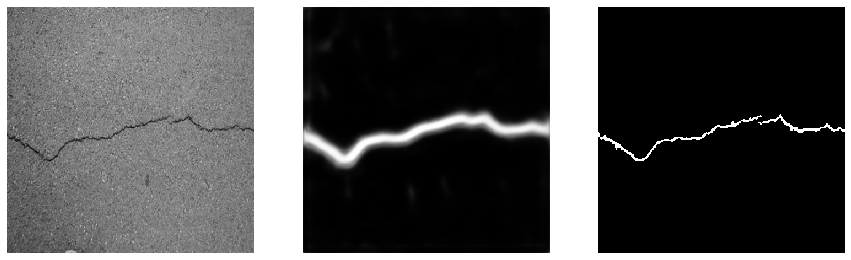

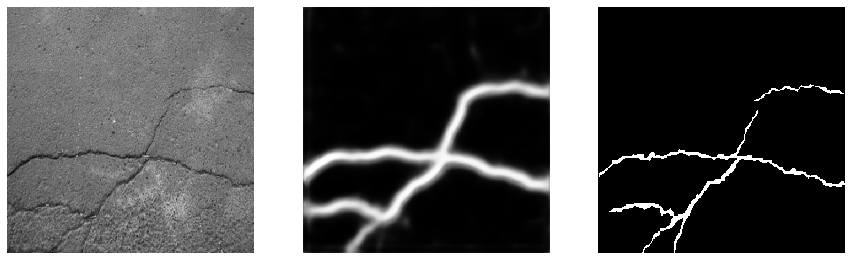

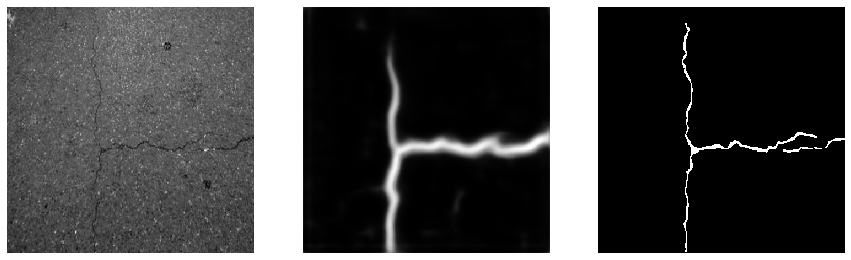

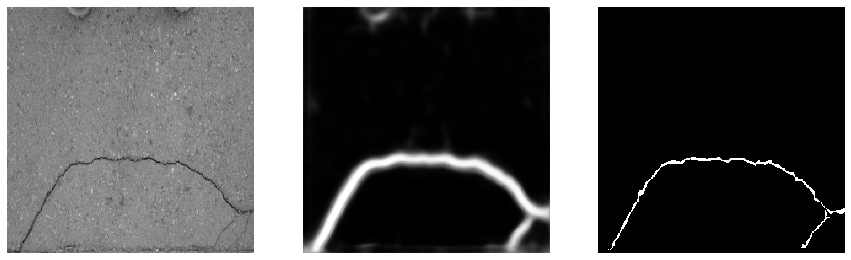

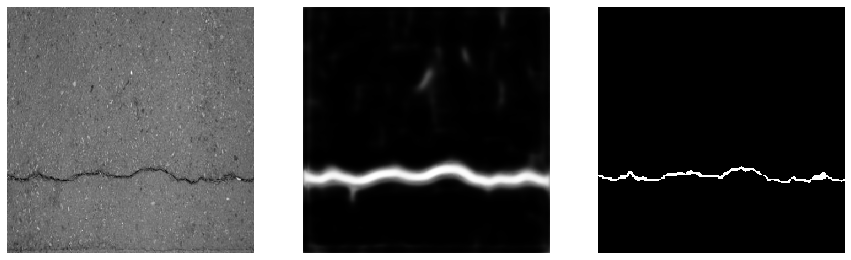

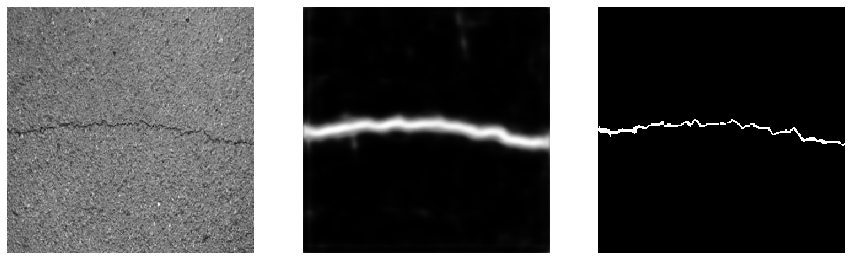

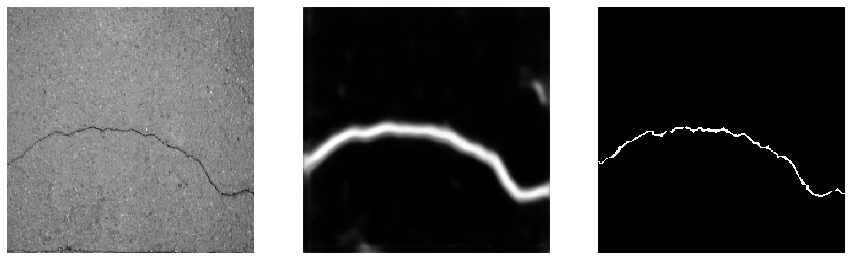

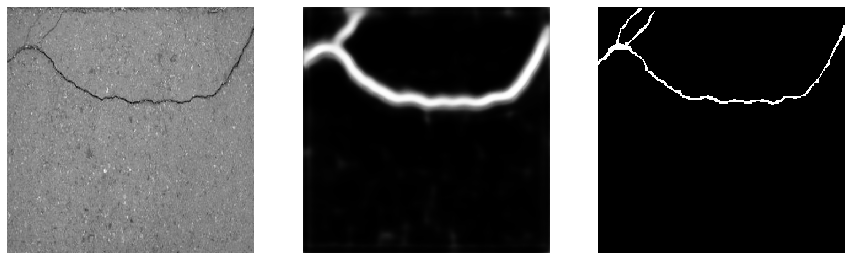

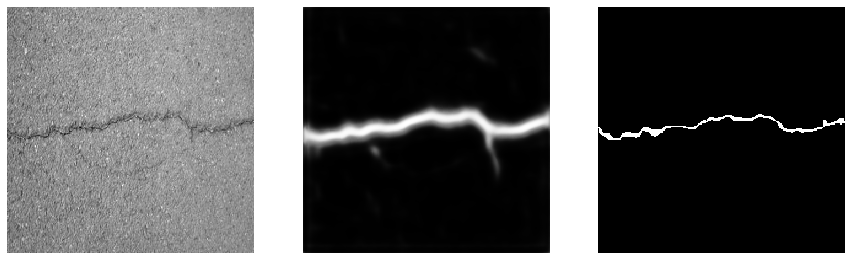

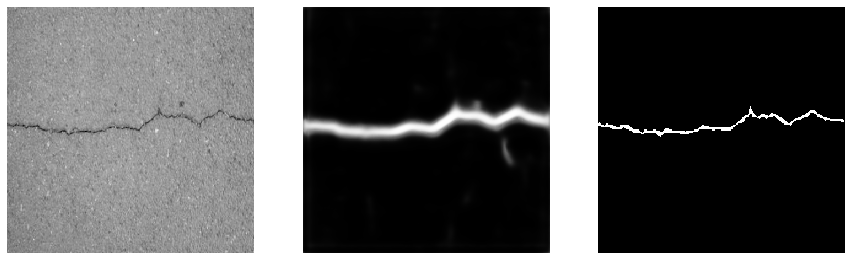

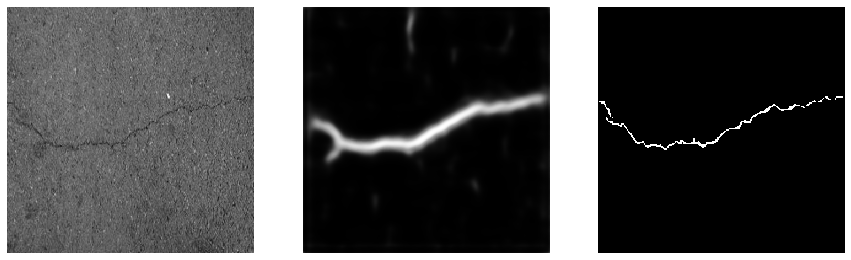

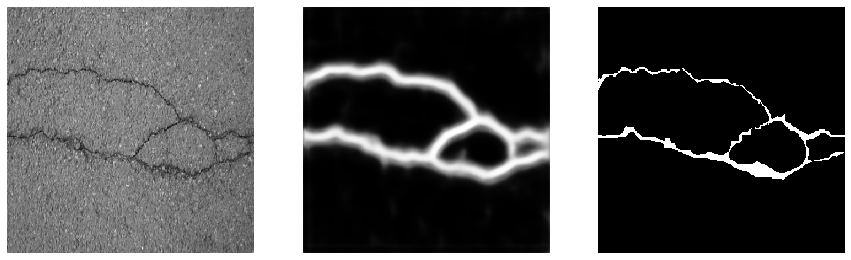

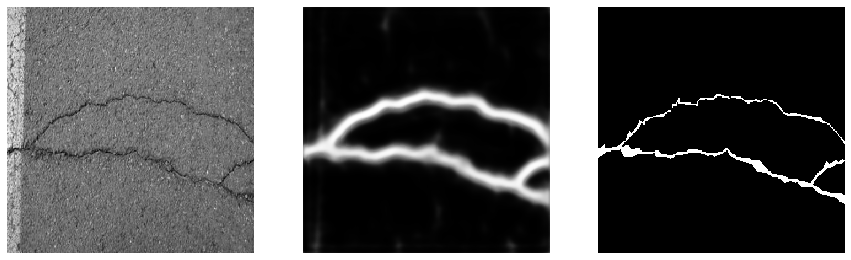

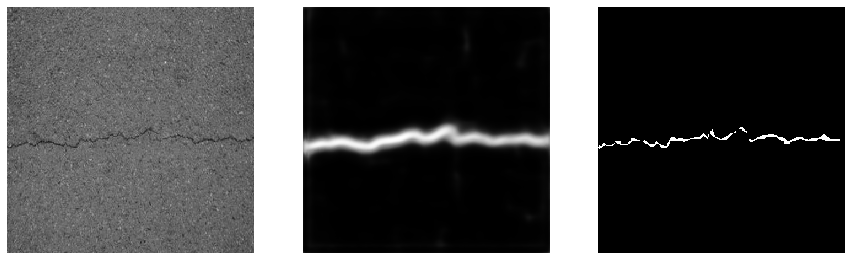

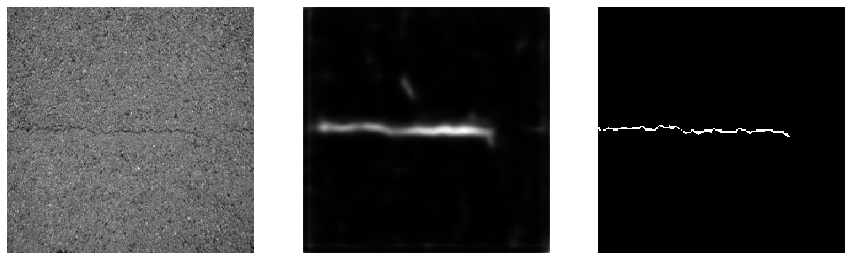

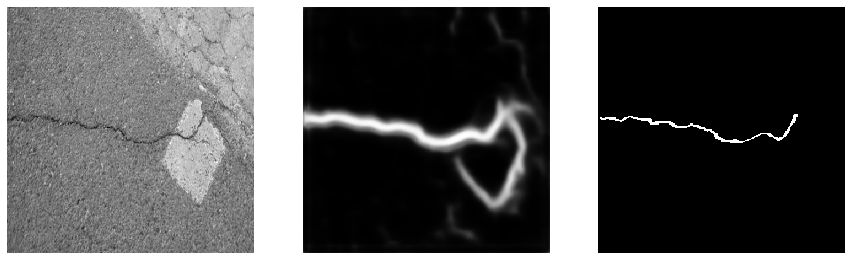

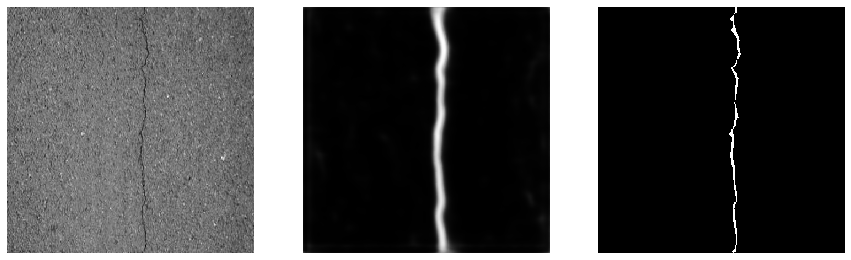

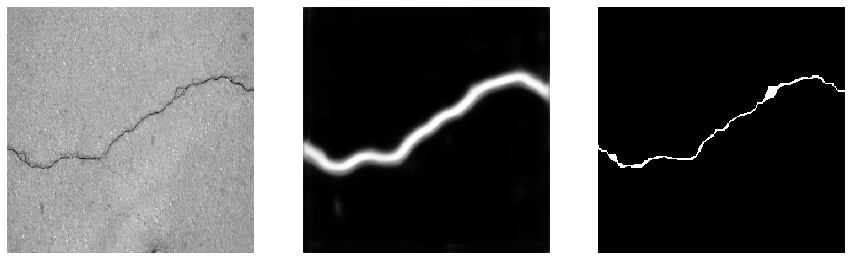

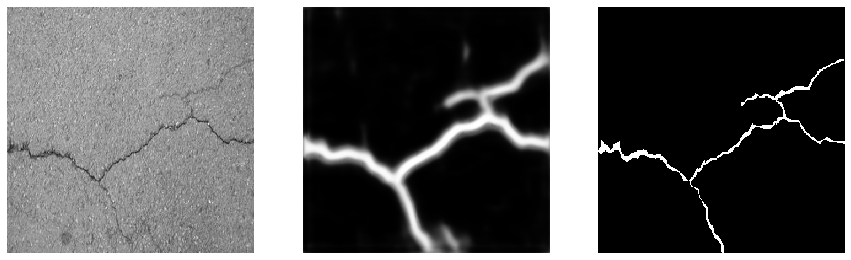

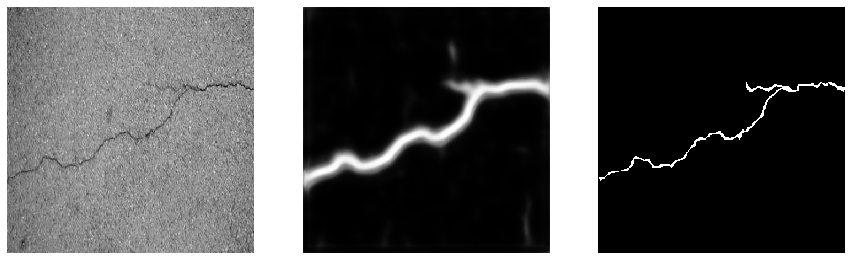

In [13]:
# 0, 10, 31, 91, 9000, 10020
idx = 0
data = train_list[idx:idx + 20]
label = label_list[idx:idx + 20]

print(data.shape)

# plt.imshow(data.reshape(448,448))
# plt.axis('off')

# plt.show()
# plt.close()

_pred = sess.run(pred, feed_dict={x:data})
print(_pred[0].shape)

# 학습 결과 이미지 출력
for i in range(data.shape[0]):
    showCrack(data[i], _pred[i], label[i])